# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernible landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [1]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

##############################
# originally (0, 1)
# normalize to (-1, 1)
##############################

train_transform = transforms.Compose([transforms.RandomRotation(10),
                                     transforms.RandomResizedCrop(32),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose([transforms.Resize((32, 32)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
##########################
# loading with transforms
##########################

train_data = torchvision.datasets.folder.ImageFolder(root='../landmark_images/train', transform=train_transform)

test_data = torchvision.datasets.folder.ImageFolder(root='../landmark_images/test', transform=train_transform)

batch_size = 20

#############################
# cross validation subsample
#############################

valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices) # in-place
split = int(np.floor(num_train * (1 - valid_size)))
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler, valid_sampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(valid_idx)

#################
# loaders
#################

trainlader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, sampler=train_sampler)

validloader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, sampler=valid_sampler)

testloader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

loaders_scratch = {'train': trainlader, 'valid': validloader, 'test': testloader}


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**:\
    * Resized the images with transform.RandomResizedCrop()\
    * Augmented the images with transform.AutoAugment()

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

<ipython-input-2-c131922d39fc>:40: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 18 / 2, idx+1, xticks=[], yticks=[])


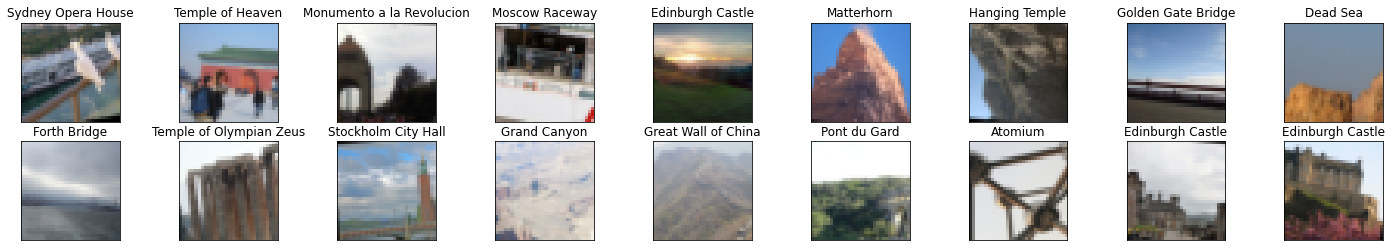

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

#######################
# defining the classes
#######################

import os
os.curdir
trainfolder = os.path.join(os.curdir, '../landmark_images/train')
classes = os.listdir(trainfolder) # only return items in arbitrary order
classes.sort() # done in-place

######################################
# somehow plt loves the range (0, 1)
######################################

def imgshow(img):
    img = img * 0.5 + 0.5 # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))

images, labels = next(iter(loaders_scratch['train']))

images = images.numpy() # NOT in-place

fig = plt.figure(figsize=(25, 4))

##########################
# only showing 18 images
# not enough space
##########################

for idx in range(18):
    ax = fig.add_subplot(2, 18 / 2, idx+1, xticks=[], yticks=[])
    imgshow(images[idx])
    ax.set_title(classes[labels[idx]].strip('1234567890.').replace('_', ' '))

### Initialize use_cuda variable

In [3]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [4]:
## TODO: select loss function
criterion_scratch = torch.nn.NLLLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    return optimizer

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [5]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN

        #################################
        # doubling every step of the way
        # Occam's Razor
        # bias=True by default
        #################################
        
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        #self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(1024, 256) # 4 * 4 * 64
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 50)
    
    def forward(self, x):
        ## Define forward behavior

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        #x = self.pool(F.relu(self.conv4(x)))
        
        x = x.view(x.shape[0], -1)        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  
* Three convolutional layers, Doubling the depth each
    * No specific reason, Occam's Razor
    * Each convolutional layer will have the same number of weights due to pooling
    * No computational resource is prioritized at any part of the chain
    * The GPU can only take up to 3 convolutional layers for its limited memory
* Three fully connected layers
    * one of them has the same num of in- and out-features
    * saw this in VGG16

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [6]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            optimizer.zero_grad()
            log_ps = model(data)
            loss = criterion(log_ps, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            log_ps = model(data)
            loss = criterion(log_ps, target)
            loss.backward()
            optimizer.step()
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))
            

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss < valid_loss_min:
            print(f"saving state_dict at {save_path}...")
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [7]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    ###############
    # m for module
    ###############
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        n = m.in_features
        m.weight.data.normal_(mean=0, std=1.0/np.sqrt(n))
        m.bias.data.fill_(0)

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 3.911307 	Validation Loss: 3.909564
saving state_dict at ignore.pt...
Epoch: 2 	Training Loss: 3.896880 	Validation Loss: 3.870019
saving state_dict at ignore.pt...
Epoch: 3 	Training Loss: 3.852153 	Validation Loss: 3.835080
saving state_dict at ignore.pt...
Epoch: 4 	Training Loss: 3.854350 	Validation Loss: 3.815293
saving state_dict at ignore.pt...
Epoch: 5 	Training Loss: 3.804035 	Validation Loss: 3.795040
saving state_dict at ignore.pt...
Epoch: 6 	Training Loss: 3.831225 	Validation Loss: 3.763092
saving state_dict at ignore.pt...
Epoch: 7 	Training Loss: 3.762200 	Validation Loss: 3.705080
saving state_dict at ignore.pt...
Epoch: 8 	Training Loss: 3.680235 	Validation Loss: 3.670222
saving state_dict at ignore.pt...
Epoch: 9 	Training Loss: 3.704051 	Validation Loss: 3.622260
saving state_dict at ignore.pt...
Epoch: 10 	Training Loss: 3.620125 	Validation Loss: 3.609354
saving state_dict at ignore.pt...
Epoch: 11 	Training Loss: 3.663296 	Validation Lo

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [8]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required

########################
# only 60 epochs needed
########################
num_epochs = 60

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.913958 	Validation Loss: 3.914447
saving state_dict at model_scratch.pt...
Epoch: 2 	Training Loss: 3.916580 	Validation Loss: 3.911458
saving state_dict at model_scratch.pt...
Epoch: 3 	Training Loss: 3.912732 	Validation Loss: 3.897657
saving state_dict at model_scratch.pt...
Epoch: 4 	Training Loss: 3.866805 	Validation Loss: 3.866579
saving state_dict at model_scratch.pt...
Epoch: 5 	Training Loss: 3.833222 	Validation Loss: 3.817933
saving state_dict at model_scratch.pt...
Epoch: 6 	Training Loss: 3.809862 	Validation Loss: 3.794372
saving state_dict at model_scratch.pt...
Epoch: 7 	Training Loss: 3.787722 	Validation Loss: 3.770996
saving state_dict at model_scratch.pt...
Epoch: 8 	Training Loss: 3.826232 	Validation Loss: 3.760432
saving state_dict at model_scratch.pt...
Epoch: 9 	Training Loss: 3.760180 	Validation Loss: 3.745849
saving state_dict at model_scratch.pt...
Epoch: 10 	Training Loss: 3.785135 	Validation Loss: 3.720423
saving state_dict at

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [9]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.191701


Test Accuracy: 20% (256/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [10]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

import torch
import torchvision
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

##############################
# 224 for vgg16
# originally (0, 1)
# normalize to (-1, 1)
##############################

train_transform = transforms.Compose([transforms.RandomRotation(10),
                                     transforms.RandomResizedCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose([transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
##########################
# loading with transforms
##########################

train_data = torchvision.datasets.folder.ImageFolder(root='../landmark_images/train', transform=train_transform)

test_data = torchvision.datasets.folder.ImageFolder(root='../landmark_images/test', transform=train_transform)

batch_size = 20

#############################
# cross validation subsample
#############################

valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices) # in-place
split = int(np.floor(num_train * (1 - valid_size)))
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler, valid_sampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(valid_idx)

#################
# loaders
#################

trainlader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, sampler=train_sampler)

validloader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, sampler=valid_sampler)

testloader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

loaders_transfer = {'train': trainlader, 'valid': validloader, 'test': testloader}


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [11]:
import torch
## TODO: select loss function
criterion_transfer = torch.nn.CrossEntropyLoss()

def get_optimizer_transfer(model):
    ## TODO: select and return an optimizer
    optimizer = torch.optim.SGD(model.classifier.parameters(), lr=0.0005)
    return optimizer

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [12]:
import torch.nn as nn
import torchvision
## TODO: Specify model architecture

model_transfer = torchvision.models.vgg16(pretrained=True)

for param in model_transfer.features.parameters():
    param.requires_grad = False

#print(model_transfer)
    
model_transfer.classifier[6] = nn.Linear(4096, 50)

print(model_transfer)

#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\ng572/.cache\torch\hub\checkpoints\vgg16-397923af.pth
4.4%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

11.7%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

19.1%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_ms

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  
* think that vgg16 would be enough
    * already taking considerable time
* changing the final output to be size 50
* using lr=0.0005 instead of lr=0.001 because of complex loss surface

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [13]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
num_epochs = 20

model_transfer = train(num_epochs, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), 
                      criterion_transfer, use_cuda, 'model_transfer.pt')

#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 3.957101 	Validation Loss: 2.330805
saving state_dict at model_transfer.pt...
Epoch: 2 	Training Loss: 1.885034 	Validation Loss: 1.453647
saving state_dict at model_transfer.pt...
Epoch: 3 	Training Loss: 1.740463 	Validation Loss: 1.200257
saving state_dict at model_transfer.pt...
Epoch: 4 	Training Loss: 1.866568 	Validation Loss: 1.074545
saving state_dict at model_transfer.pt...
Epoch: 5 	Training Loss: 1.673821 	Validation Loss: 0.952668
saving state_dict at model_transfer.pt...
Epoch: 6 	Training Loss: 1.664638 	Validation Loss: 0.828990
saving state_dict at model_transfer.pt...
Epoch: 7 	Training Loss: 1.703608 	Validation Loss: 0.755311
saving state_dict at model_transfer.pt...
Epoch: 8 	Training Loss: 1.622314 	Validation Loss: 0.734182
saving state_dict at model_transfer.pt...
Epoch: 9 	Training Loss: 1.634460 	Validation Loss: 0.668658
saving state_dict at model_transfer.pt...
Epoch: 10 	Training Loss: 1.668807 	Validation Loss: 0.642105
saving stat

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [14]:
###################
# if not already,
# load state dict
###################

model_transfer.load_state_dict(torch.load('model_transfer.pt'))

test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.524483


Test Accuracy: 64% (812/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [15]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    PILimg = Image.open(img_path)
    algorithm_transform = transforms.Compose([transforms.Resize((224, 224)),
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    img_tensor = algorithm_transform(PILimg)
    img_tensor = torch.unsqueeze(img_tensor, 0)
    if use_cuda:
        img_tensor = img_tensor.cuda()
    model_transfer.eval()
    output = model_transfer(img_tensor)
    #print(output.squeeze(0))
    top_score, top_pos = torch.topk(output.squeeze(0), k)
    result_list = []
    for idx in top_pos:
        result_list.append(classes[idx].lstrip('0123456789.'))
    return result_list

# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['Golden_Gate_Bridge',
 'Forth_Bridge',
 'Dead_Sea',
 'Brooklyn_Bridge',
 'Sydney_Harbour_Bridge']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

Is this picture of the Golden_Gate_Bridge, Forth_Bridge, or Dead_Sea?


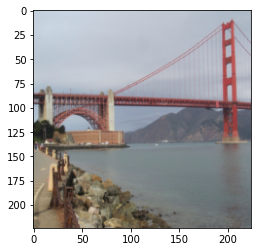

In [16]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions
    PILimg = Image.open(img_path)
    user_transform = transforms.Compose([transforms.Resize((224, 224)),
                                         transforms.ToTensor()])
    img_tensor = user_transform(PILimg)
    plt.imshow(np.transpose(img_tensor, (1, 2, 0)))
    print(f"Is this picture of the {predicted_landmarks[0]}, {predicted_landmarks[1]}, or {predicted_landmarks[2]}?")
    
# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)
* the output is good if we consider the top 3 candidates
    * all 4 queries returned at least one correct answer
* possible improvements
    * train on native images rather than using pretrained
    * allow user to choose a specific portion of image as input, prediction more specific
    * experiment with different learn rates due to complexity in loss surface

Is this picture of the Eiffel_Tower, Forth_Bridge, or Golden_Gate_Bridge?
Is this picture of the Soreq_Cave, Great_Barrier_Reef, or Sydney_Opera_House?
Is this picture of the Atomium, Sydney_Harbour_Bridge, or Niagara_Falls?
Is this picture of the Machu_Picchu, Great_Wall_of_China, or Mount_Rainier_National_Park?


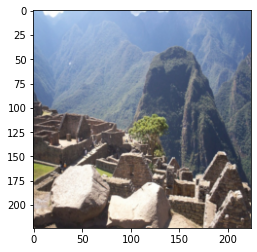

In [17]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.

suggest_locations('images/test/16.Eiffel_Tower/3828627c8730f160.jpg')
suggest_locations('images/test/24.Soreq_Cave/18dbbad48a83a742.jpg')
suggest_locations('images/test/37.Atomium/5ecb74282baee5aa.jpg')
suggest_locations('images/test/41.Machu_Picchu/4336abf3179202f2.jpg')